In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("movie_titles.csv")
display(df.head())

## GLOBAL PARAMETERS
MAX_POPULARITY = 150.

,movie,year,title,id_moviedb,popularity,genre_ids,vote_average,media_type,genre.Horror,genre.Adventure,...,genre.Romance,genre.Fantasy,genre.Crime,genre.Drama,genre.Music,genre.Family,genre.History,genre.TV Movie,genre.War,genre.Western
0,1,2003,Dinosaur Planet,58691,5.811,"[12, 878]",3.2,movie,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1997,Character,655068,0.638,[99],0.0,movie,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1994,Paula Abdul's Get Up & Dance,274766,0.6,[],0.0,movie,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,2004,The Rise and Fall of ECW,33209,8.265,[99],8.3,movie,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,1997,Sick,308867,6.121,"[878, 27]",5.4,movie,1,0,...,0,0,0,0,0,0,0,0,0,0


Feature: popularity (per https://developers.themoviedb.org/3/getting-started/popularity)
count    16251.000000
mean        12.309070
std         21.805923
min          0.600000
25%          4.099500
50%          7.443000
75%         12.585500
max       1053.025000
Name: popularity, dtype: float64

Found 46 entries with missing popularity
Clipping value for 58 entries with popularity >150.00



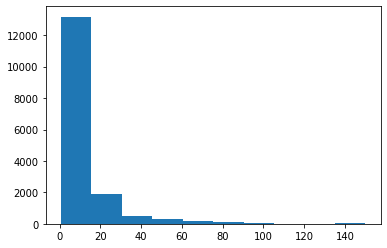

In [3]:
print("Feature: popularity (per https://developers.themoviedb.org/3/getting-started/popularity)")
popularity = pd.to_numeric(df["popularity"], errors='coerce')
print(popularity.describe())
print()
print("Found %d entries with missing popularity" % popularity.isna().sum())
print("Clipping value for %d entries with popularity >%.02f" % ((popularity>MAX_POPULARITY).sum(), MAX_POPULARITY))
popularity = popularity.clip(upper=MAX_POPULARITY)
plt.hist(popularity)
print()

Feature: year
count    16297.000000
mean      1990.539670
std         16.084435
min       1914.000000
25%       1985.000000
50%       1997.000000
75%       2002.000000
max       2005.000000
Name: year, dtype: float64

Found 0 entries with missing year



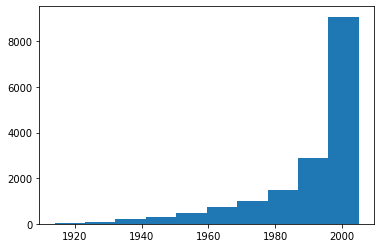

In [4]:
print("Feature: year")
year = pd.to_numeric(df["year"], downcast="unsigned", errors='coerce')
print(year.describe())
print()
print("Found %d entries with missing year" % year.isna().sum())
plt.hist(year)
print()

In [5]:
print("Feature: media_type")
media_type = df["media_type"]
print(media_type.describe())
print()
for i in media_type.unique():
    print("%d %s entries" % ((media_type==i).sum(), i))
print("Found %d entries with missing media_type" % media_type.isna().sum())
print()

Feature: media_type
count     16251
unique        2
top       movie
freq      14124
Name: media_type, dtype: object

14124 movie entries
2127 tv entries
0 nan entries
Found 46 entries with missing media_type



Feature: vote_average
count    16251.000000
mean        11.964999
std         16.732349
min          0.600000
25%          4.099500
50%          7.443000
75%         12.585500
max        150.000000
Name: popularity, dtype: float64

Found 46 entries with missing vote_average



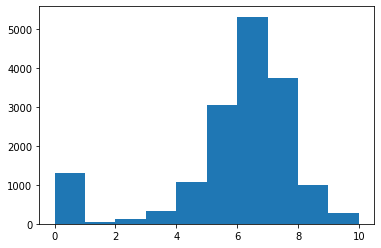

In [6]:
print("Feature: vote_average")
vote_average = pd.to_numeric(df["vote_average"], errors='coerce')
print(popularity.describe())
print()
print("Found %d entries with missing vote_average" % vote_average.isna().sum())
plt.hist(vote_average)
print()

,genre.Horror,genre.Adventure,genre.Science Fiction,genre.Documentary,genre.Animation,genre.Action,genre.Comedy,genre.Thriller,genre.Mystery,genre.Romance,genre.Fantasy,genre.Crime,genre.Drama,genre.Music,genre.Family,genre.History,genre.TV Movie,genre.War,genre.Western
genre.Horror,1.000000,-0.058341,0.188727,-0.081267,-0.069059,-0.026173,-0.091937,0.175578,0.088877,-0.111265,0.067682,-0.061928,-0.172368,-0.080053,-0.086319,-0.043592,-0.005991,-0.045561,-0.033302
genre.Adventure,-0.058341,1.000000,0.144364,-0.081349,0.109332,0.287043,-0.004888,0.023153,-0.040046,-0.043851,0.215047,-0.043376,-0.079188,-0.048888,0.217417,0.047800,-0.009673,0.047213,0.042092
genre.Science Fiction,0.188727,0.144364,1.000000,-0.073440,0.044545,0.165057,-0.038878,0.086106,0.007781,-0.068527,0.141983,-0.067395,-0.142751,-0.070759,0.018678,-0.047320,-0.002025,-0.033268,-0.029289
genre.Documentary,-0.081267,-0.081349,-0.073440,1.000000,-0.077139,-0.116398,-0.160311,-0.125855,-0.069954,-0.120742,-0.068778,-0.095405,-0.227579,0.165457,-0.065001,0.036152,-0.014755,-0.008667,-0.043131
genre.Animation,-0.069059,0.109332,0.044545,-0.077139,1.000000,-0.044237,0.038656,-0.113609,-0.017103,-0.084134,0.142920,-0.084636,-0.156485,-0.033210,0.307968,-0.045731,-0.006108,-0.045702,-0.037602
genre.Action,-0.026173,0.287043,0.165057,-0.116398,-0.044237,1.000000,-0.071556,0.258640,-0.046294,-0.106577,0.059830,0.151431,-0.064053,-0.104627,-0.049824,0.005926,-0.006243,0.070503,0.054117
genre.Comedy,-0.091937,-0.004888,-0.038878,-0.160311,0.038656,-0.071556,1.000000,-0.185044,-0.081150,0.172134,0.045729,-0.050510,-0.138699,-0.047599,0.113089,-0.096381,-0.029468,-0.078566,-0.030055
genre.Thriller,0.175578,0.023153,0.086106,-0.125855,-0.113609,0.258640,-0.185044,1.000000,0.252031,-0.082199,-0.037796,0.281075,0.028582,-0.115088,-0.117641,-0.043813,0.002432,-0.022370,-0.041740
genre.Mystery,0.088877,-0.040046,0.007781,-0.069954,-0.017103,-0.046294,-0.081150,0.252031,1.000000,-0.056858,-0.015870,0.183367,0.071141,-0.062687,-0.052658,-0.038884,0.003782,-0.031771,-0.030325
genre.Romance,-0.111265,-0.043851,-0.068527,-0.120742,-0.084134,-0.106577,0.172134,-0.082199,-0.056858,1.000000,0.013058,-0.073077,0.222396,0.003442,-0.053135,-0.017815,-0.010076,0.010017,0.001197


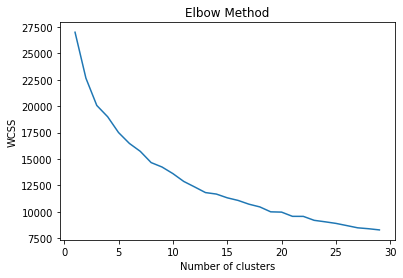

In [7]:
genre_cols = [col for col in df if col.startswith("genre.")]

genre_df = df[genre_cols]
genre_corr = genre_df.corr()
display(genre_corr.style.background_gradient(cmap='coolwarm'))

wcss = []
max_cluster_count = 30
for i in range(1, max_cluster_count):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[genre_cols])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, max_cluster_count), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

,popularity,vote_average
popularity,1.000000,0.264565
vote_average,0.264565,1.000000


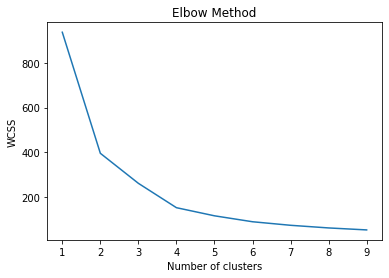

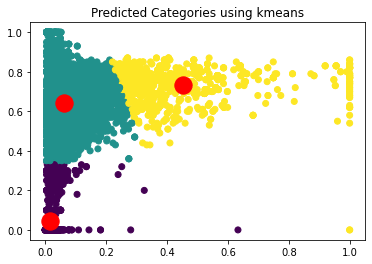

In [9]:
scaler = MinMaxScaler()
p = scaler.fit_transform(popularity.fillna(0.).values.reshape(-1, 1)) # TODO: remove imputation
v = scaler.fit_transform(vote_average.fillna(0.).values.reshape(-1, 1)) # TODO: remove imputation
rating_df = pd.DataFrame({ "popularity": pd.Series(p.T[0]), "vote_average": pd.Series(v.T[0])})
rating_corr = rating_df.corr()
display(rating_corr.style.background_gradient(cmap='coolwarm'))

wcss = []
max_cluster_count = 10
for i in range(1, max_cluster_count):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rating_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, max_cluster_count), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(rating_df)
plt.scatter(p, v, c=clusters)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title('Predicted Categories using kmeans')
plt.show()